In [1]:
import torch

# Dynamically choose GPU (cuda) if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from statistics import mode, median
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.optim as optim
random.seed(4)
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
# Base directory for the dataset
dataset_path = '/Users/jalecia/Neudesic/Signature Verification/UTSig'

# Subdirectories
skilled_forgery = os.path.join(dataset_path, 'Forgery', 'Skilled')
genuine = os.path.join(dataset_path, 'Genuine')

# Optional: Check that the paths are valid and list files
print("Skilled forgeries:", len(os.listdir(skilled_forgery)))
print("Genuine signatures:", len(os.listdir(genuine)))


Skilled forgeries: 116
Genuine signatures: 96


In [4]:
directory = '/Users/jalecia/Neudesic/Signature Verification/UTSig' 

genuine_path = os.path.join(directory, "Genuine")
forgery_path = os.path.join(directory, "Forgery")

forgery_subdirs = ["Opposite Hand", "Simple", "Skilled"]


In [5]:
unique_folders = set(os.listdir(genuine_path)) & set(os.listdir(os.path.join(forgery_path, forgery_subdirs[0])))

selected_folders = random.sample(list(unique_folders), 5)

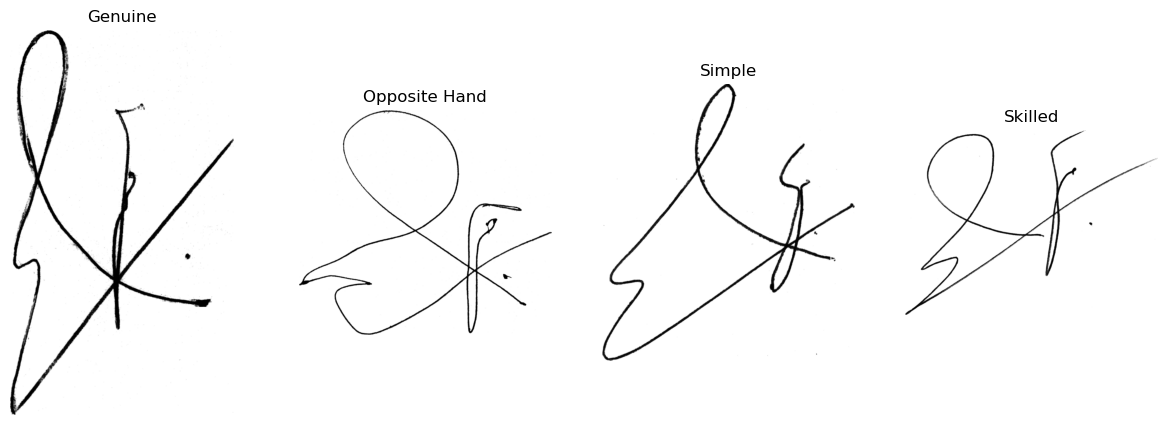

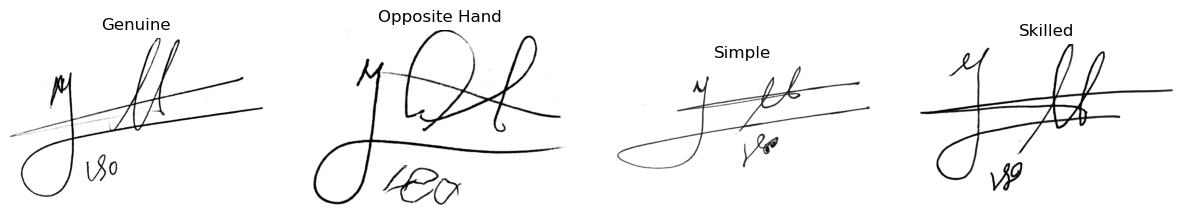

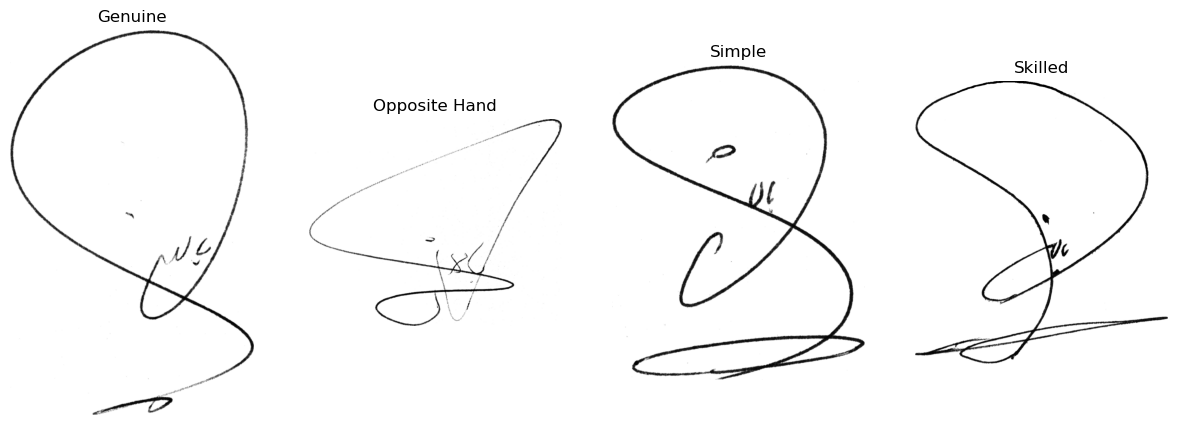

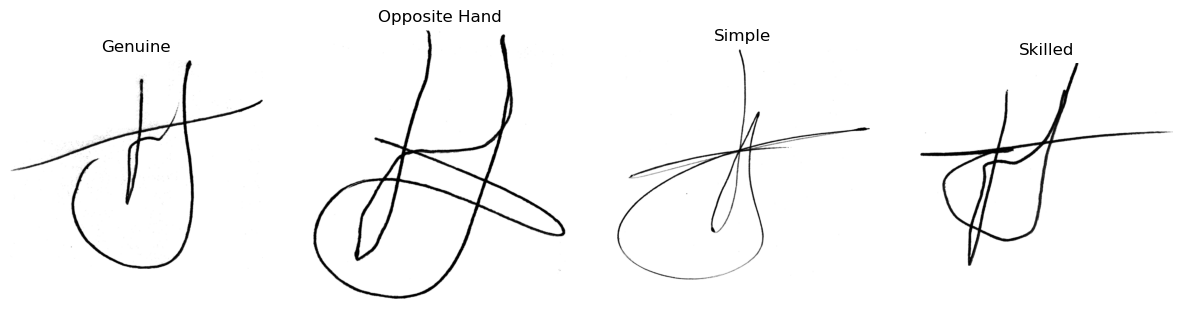

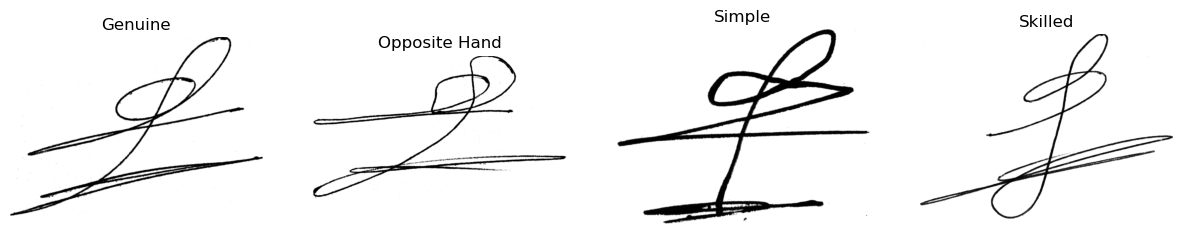

In [6]:
for subfolder in selected_folders:
    images = []
    titles = ["Genuine", "Opposite Hand", "Simple", "Skilled"]
    
    genuine_images = [f for f in os.listdir(os.path.join(genuine_path, subfolder)) if f.endswith(".tif")]
    if genuine_images:
        images.append(Image.open(os.path.join(genuine_path, subfolder, genuine_images[0])))

    for subdir in forgery_subdirs:
        forgery_images = [f for f in os.listdir(os.path.join(forgery_path, subdir, subfolder)) if f.endswith(".tif")]
        if forgery_images:
            images.append(Image.open(os.path.join(forgery_path, subdir, subfolder, forgery_images[0])))

    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray") 
        ax.set_title(title)
        ax.axis("off")

    plt.show()

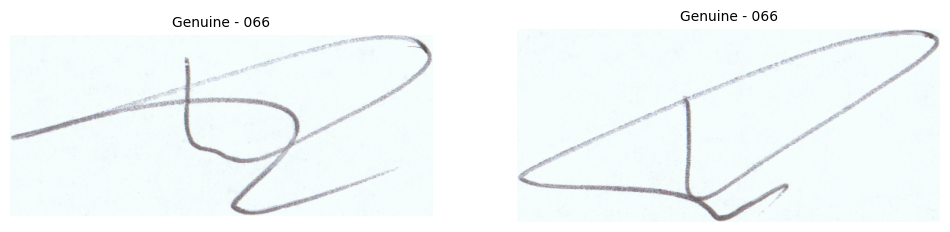

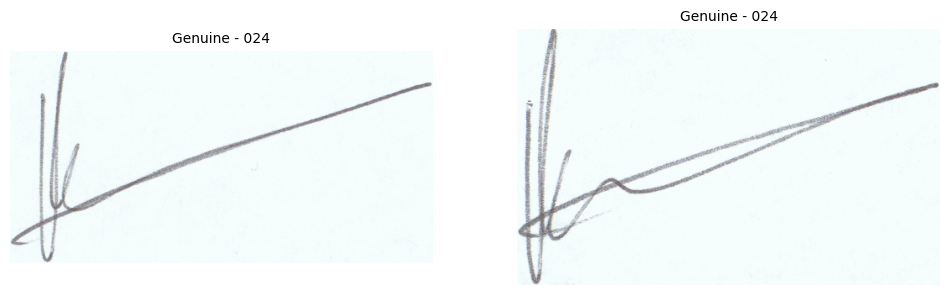

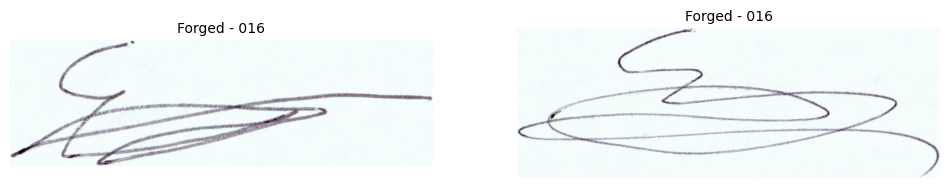

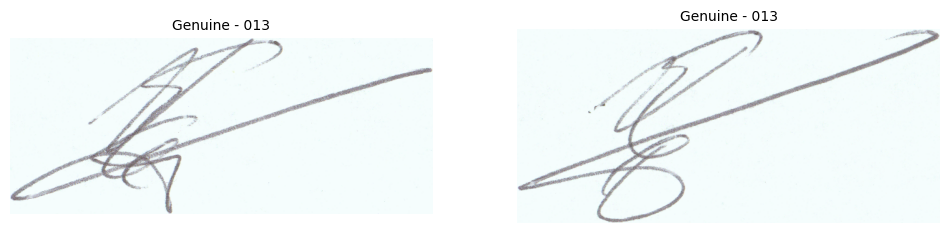

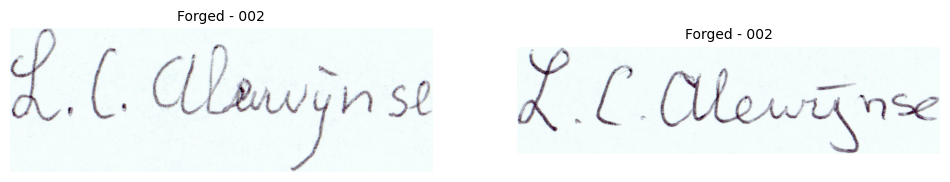

In [7]:
dataset_path = "/Users/jalecia/Neudesic/Signature Verification/train"

genuine_folders = sorted([f for f in os.listdir(dataset_path) if not f.endswith("_forg")])

selected_folders = random.sample(genuine_folders, 5)

for folder in selected_folders:
    images = []
    titles = []

    genuine_path = os.path.join(dataset_path, folder)
    forg_path = os.path.join(dataset_path, folder + "_forg")

    genuine_images = [f for f in os.listdir(genuine_path) if f.endswith(".png")]
    genuine_images = random.sample(genuine_images, min(2, len(genuine_images))) 

    forg_images = [f for f in os.listdir(forg_path) if f.endswith(".png")]
    forg_images = random.sample(forg_images, min(2, len(forg_images))) 

    for img_name in genuine_images:
        images.append(Image.open(os.path.join(genuine_path, img_name)))
        titles.append(f"Genuine - {folder}")

    for img_name in forg_images:
        images.append(Image.open(os.path.join(forg_path, img_name)))
        titles.append(f"Forged - {folder}")

    fig, axes = plt.subplots(1, len(images), figsize=(12, 5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray") 
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    plt.show()

In [8]:
genuine_folders = sorted([
    f for f in os.listdir(dataset_path)
    if not f.endswith("_forg") and not f.startswith('.')
])
print(f"Found {len(genuine_folders)} genuine signer folders.")

# Initialize containers
genuine_image_counts = set()
forged_image_counts = set()
image_dimensions_set = set()
total_number_of_training_examples = 0

# Define valid image file extensions
valid_exts = (".png", ".tif", ".jpg", ".jpeg")

for folder in genuine_folders:
    genuine_path = os.path.join(dataset_path, folder)
    forg_path = os.path.join(dataset_path, folder + "_forg")

    # Load and count genuine images
    if os.path.exists(genuine_path):
        gen_imgs = [f for f in os.listdir(genuine_path) if f.endswith(valid_exts)]
        genuine_image_counts.add(len(gen_imgs))

        for img in gen_imgs:
            img_path = os.path.join(genuine_path, img)
            try:
                with Image.open(img_path) as im:
                    image_dimensions_set.add(im.size)
            except Exception as e:
                print(f"Error opening {img_path}: {e}")
    else:
        print(f"Missing: {genuine_path}")

    # Load and count forged images
    if os.path.exists(forg_path):
        forg_imgs = [f for f in os.listdir(forg_path) if f.endswith(valid_exts)]
        forged_image_counts.add(len(forg_imgs))

        for img in forg_imgs:
            img_path = os.path.join(forg_path, img)
            try:
                with Image.open(img_path) as im:
                    image_dimensions_set.add(im.size)
            except Exception as e:
                print(f"Error opening {img_path}: {e}")
    else:
        print(f"Missing: {forg_path}")

    # Safely compute training pair combinations (genuine × forged)
    if os.path.exists(genuine_path) and os.path.exists(forg_path):
        total_number_of_training_examples += len(gen_imgs) * len(forg_imgs)

# Final summary
print("\n--- Dataset Summary ---")
print(f"Total unique image shapes: {len(image_dimensions_set)} → {image_dimensions_set}")
print(f"Range of genuine image counts per signer: {sorted(genuine_image_counts)}")
print(f"Range of forged image counts per signer: {sorted(forged_image_counts)}")
print(f"Total training examples (genuine × forged combinations): {total_number_of_training_examples}")

Found 64 genuine signer folders.

--- Dataset Summary ---
Total unique image shapes: 770 → {(410, 294), (605, 390), (736, 306), (521, 229), (321, 204), (783, 238), (653, 537), (314, 177), (627, 256), (601, 356), (613, 321), (842, 302), (550, 301), (650, 150), (740, 443), (468, 119), (1004, 242), (690, 204), (560, 113), (596, 286), (757, 203), (457, 347), (415, 103), (852, 239), (393, 201), (615, 375), (352, 172), (803, 346), (541, 108), (715, 233), (718, 406), (436, 162), (614, 187), (759, 425), (885, 272), (324, 366), (375, 179), (449, 217), (817, 393), (667, 296), (1026, 405), (976, 386), (680, 244), (1296, 485), (600, 144), (781, 165), (805, 284), (774, 278), (754, 458), (646, 367), (1221, 320), (603, 396), (757, 225), (647, 341), (812, 399), (589, 507), (712, 321), (415, 107), (471, 133), (806, 352), (494, 336), (657, 143), (720, 190), (645, 434), (287, 299), (503, 341), (804, 180), (482, 138), (653, 127), (714, 143), (619, 134), (706, 139), (431, 181), (723, 228), (477, 297), (575

In [9]:
widths = [dim[0] for dim in image_dimensions_set]
heights = [dim[1] for dim in image_dimensions_set]

width_mean = np.mean(widths)
height_mean = np.mean(heights)

width_median = median(widths)
height_median = median(heights)

try:
    width_mode = mode(widths)
except:
    width_mode = "No unique mode"

try:
    height_mode = mode(heights)
except:
    height_mode = "No unique mode"

print(f"Width - Mean: {width_mean}, Median: {width_median}, Mode: {width_mode}")
print(f"Height - Mean: {height_mean}, Median: {height_median}, Mode: {height_mode}")

Width - Mean: 653.8571428571429, Median: 650.0, Mode: 631
Height - Mean: 277.61948051948053, Median: 267.0, Mode: 257


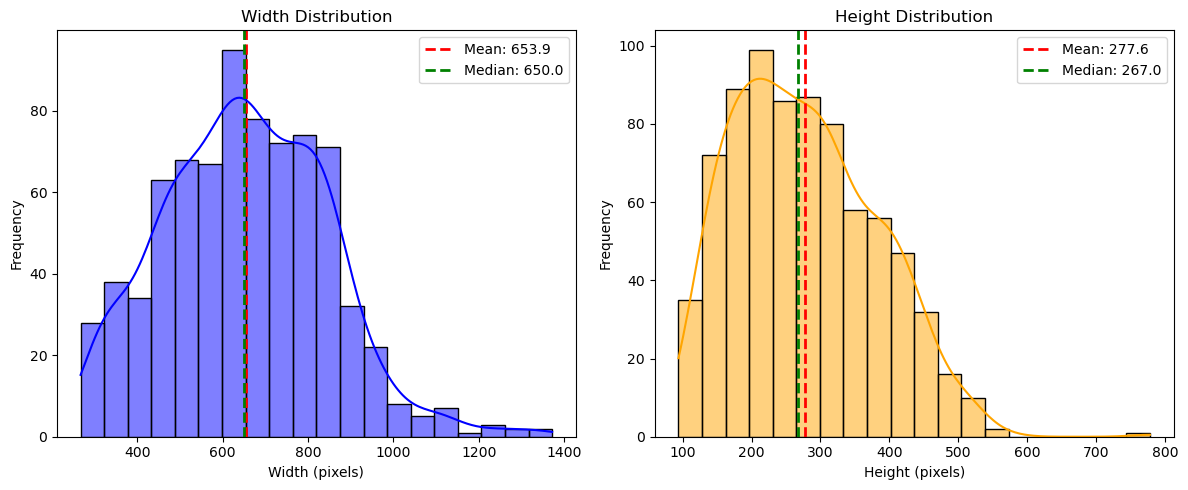

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True, bins=20, color="blue")
plt.axvline(np.mean(widths), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {np.mean(widths):.1f}")
plt.axvline(median(widths), color='green', linestyle='dashed', linewidth=2, label=f"Median: {median(widths):.1f}")
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True, bins=20, color="orange")
plt.axvline(np.mean(heights), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {np.mean(heights):.1f}")
plt.axvline(median(heights), color='green', linestyle='dashed', linewidth=2, label=f"Median: {median(heights):.1f}")
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def get_signature_dataloader(root_dir, batch_size=32,
                             train_ratio=0.7, val_ratio=0.15):
    
    TARGET_SIZE = (270, 650)

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(TARGET_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
 
    dataset = SignatureDataset(root_dir, transform=transform)
    total = len(dataset)
 
    train_size = int(train_ratio * total)
    val_size   = int(val_ratio   * total)
    test_size  = total - (train_size + val_size)

    generator = torch.Generator().manual_seed(42)
    train_ds, val_ds, test_ds = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=generator
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                              shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):

        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=9, stride=1, padding=4), 
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),  
            nn.Dropout2d(p=0.2),
        
            nn.Conv2d(20, 40, kernel_size=7, stride=1, padding=3), 
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.2),
        
            nn.Conv2d(40, 80, kernel_size=5, stride=1, padding=2),  
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.2),
        
            nn.Conv2d(80, 160, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2), 
            nn.AdaptiveAvgPool2d((4, 4)), 
            nn.Dropout2d(p=0.2),
        )


        self.fc1 = nn.Sequential(
            nn.Linear(2560, 640),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(640, 160),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(160,40),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(40,10) 
        )

    def _get_flattened_size(self, x1, x2):

        x = self.cnn1(x)
        return x.view(x.size(0), -1).shape[1]

    def forward_once(self, x1, x2):
        
        x = self.cnn1(x)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
       
        diff    = x0 - x1
        dist_sq = torch.sum(torch.pow(diff ,2),1)

        epsilon = 1e-8
        dist = torch.sqrt(dist_sq+epsilon)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=epsilon)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss


    @torch.no_grad()
    def accuracy(self, x0, x1, y, threshold=None):

        diff  = x0 - x1
        dist  = torch.sqrt(torch.sum(torch.pow(diff ,2), 1) + 1e-8)
        if threshold is None:
            threshold = self.margin
        preds = (dist < threshold).float()
        return (preds == y).float().mean().item()

In [13]:
# Uses: numpy, matplotlib.pyplot, sklearn.metrics.confusion_matrix, sklearn.metrics.ConfusionMatrixDisplay
def plot_training_history_with_confusion_matrix_v2(train_losses=None, val_losses=None,
                                                   train_accuracies=None, val_accuracies=None,
                                                   y_true=None, y_pred=None,
                                                   class_names=None):


    # Determine which plots to show
    has_loss = train_losses is not None and val_losses is not None
    has_accuracy = train_accuracies is not None and val_accuracies is not None
    has_confusion_matrix = y_true is not None and y_pred is not None

    # Determine the number of subplots
    num_plots = sum([has_loss, has_accuracy, has_confusion_matrix])

    if num_plots == 0:
        print("No data provided for plotting.")
        return

    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    if num_plots == 1:
        axes = [axes]  # Ensure it's iterable

    plot_idx = 0

    # Plot Training and Validation Loss
    if has_loss:
        epochs = range(1, len(train_losses) + 1)
        axes[plot_idx].plot(epochs, train_losses, label="Train Loss", color="red", marker="o")
        axes[plot_idx].plot(epochs, val_losses, label="Validation Loss", color="green", marker="o")
        axes[plot_idx].set_title("Train vs Validation Loss")
        axes[plot_idx].set_xlabel("Epochs")
        axes[plot_idx].set_ylabel("Loss")
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
        plot_idx += 1

    # Plot Training and Validation Accuracy
    if has_accuracy:
        epochs = range(1, len(train_accuracies) + 1)
        axes[plot_idx].plot(epochs, train_accuracies, label="Train Accuracy", color="red", marker="o")
        axes[plot_idx].plot(epochs, val_accuracies, label="Validation Accuracy", color="green", marker="o")
        axes[plot_idx].set_title("Train vs Validation Accuracy")
        axes[plot_idx].set_xlabel("Epochs")
        axes[plot_idx].set_ylabel("Accuracy")
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
        plot_idx += 1

    # Compute and display the confusion matrix
    if has_confusion_matrix:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=axes[plot_idx], cmap='Blues', values_format='d')
        axes[plot_idx].set_title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

In [14]:
def train(net, train_loader, val_loader, device, epochs, patience, lr=None, weight_decay=None, monitor_metric="val_loss", optimizer=None, scheduler=None, criterion=None):
    best_val_acc = 0
    best_model_state = None
    best_epoch = 0
    no_improve_epochs = 0

    if optimizer is None:
        if lr is None or weight_decay is None:
            raise ValueError("lr and weight_decay must be provided if optimizer is not passed.")
        optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # Use provided loss function or default to unweighted CrossEntropy
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        net.train()
        total_loss, correct, total = 0, 0, 0

        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.long().to(device)


            optimizer.zero_grad()
            outputs = net(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * img1.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_loss / total
        train_acc = correct / total

        net.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.long().to(device)
                outputs = net(img1, img2)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * img1.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / total
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Epoch {epoch+1:02d} | Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if scheduler:
            scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = net.state_dict()
            best_epoch = epoch
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
                break

    print(f"Best model saved with validation accuracy = {best_val_acc:.4f}")
    net.load_state_dict(best_model_state)
    return net, history


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_dir = "/Users/jalecia/Neudesic/Signature Verification/train"

train_loader, val_loader, test_loader = get_signature_dataloader(
    root_dir,
    batch_size=16,
    train_ratio=0.7,  
    val_ratio=0.15) 

In [16]:
from signature_dataset import SignatureDataset

In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Get the actual dataset and indices
subset = train_loader.dataset
base_dataset = subset.dataset
subset_indices = subset.indices

# Collect labels from the subset
all_labels = [int(base_dataset[i][2]) for i in subset_indices]
  # this uses __getitem__

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [20]:
# ===== Class Weight Calculation =====

from sklearn.utils.class_weight import compute_class_weight

# Get the base dataset and the subset indices
subset = train_loader.dataset
base_dataset = subset.dataset
subset_indices = subset.indices

# Extract the true labels (the third item in each returned tuple)
all_labels = [int(base_dataset[i][2]) for i in subset_indices]

# Compute class weights
classes = np.unique(all_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [21]:
# ===== Updated Data Augmentation =====

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [28]:
import torch.nn.functional as F

In [29]:
net = SignatureNet(input_size=(1, 270, 650)).to(device)


In [24]:
class SignatureNet(nn.Module):
    def __init__(self, input_size=(1, 270, 650)):  # accepts input_size
        super(SignatureNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        # Compute flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_output = self._forward_conv(dummy_input)
            flatten_size = dummy_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, 2)

    def _forward_conv(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        return x

    def embed(self, x):
        x = self._forward_conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def forward(self, x1, x2):
        out1 = self.embed(x1)
        out2 = self.embed(x2)
        diff = torch.abs(out1 - out2)
        return self.classifier(diff)


In [30]:
# ===== Learning Rate Scheduler (after optimizer) =====
net = SignatureNet()  # or whatever your model class is called
net.to(device)        # move it to GPU or CPUq


optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, weight_decay=5e-4)

# After defining optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [33]:
# ===== Updated Training Call with EarlyStopping Adjustments =====
model, history = train(
    net=net,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=35,
    patience=10,
    lr=5e-4,
    weight_decay=5e-4,
    monitor_metric="val_loss"
)

Epoch 01 | Train Loss: 0.0130 | Train Acc: 0.9986
Epoch 01 | Val   Loss: 0.0065 | Val   Acc: 0.9992
Epoch 02 | Train Loss: 0.0068 | Train Acc: 0.9990
Epoch 02 | Val   Loss: 0.0025 | Val   Acc: 1.0000
Epoch 03 | Train Loss: 0.0013 | Train Acc: 1.0000
Epoch 03 | Val   Loss: 0.0077 | Val   Acc: 0.9992
Epoch 04 | Train Loss: 0.0123 | Train Acc: 0.9983
Epoch 04 | Val   Loss: 0.0022 | Val   Acc: 1.0000
Epoch 05 | Train Loss: 0.0012 | Train Acc: 0.9999
Epoch 05 | Val   Loss: 0.0018 | Val   Acc: 1.0000
Epoch 06 | Train Loss: 0.0028 | Train Acc: 0.9998
Epoch 06 | Val   Loss: 0.0030 | Val   Acc: 0.9992
Epoch 07 | Train Loss: 0.0008 | Train Acc: 1.0000
Epoch 07 | Val   Loss: 0.0015 | Val   Acc: 1.0000
Epoch 08 | Train Loss: 0.0125 | Train Acc: 0.9984
Epoch 08 | Val   Loss: 0.0089 | Val   Acc: 0.9988
Epoch 09 | Train Loss: 0.0030 | Train Acc: 0.9998
Epoch 09 | Val   Loss: 0.0021 | Val   Acc: 1.0000
Epoch 10 | Train Loss: 0.0036 | Train Acc: 0.9994
Epoch 10 | Val   Loss: 0.0028 | Val   Acc: 0.9996


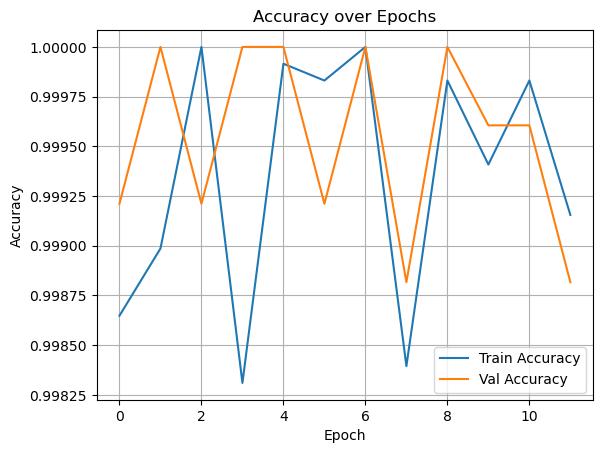

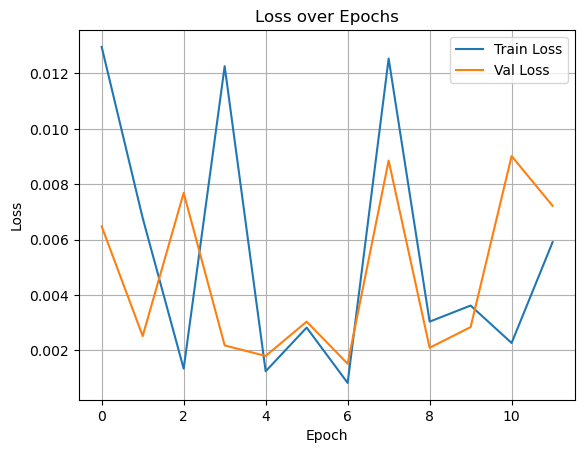

In [34]:

# === Plotting Accuracy and Loss ===
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history["train_acc"], label='Train Accuracy')
plt.plot(history["val_acc"], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(history["train_loss"], label='Train Loss')
plt.plot(history["val_loss"], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


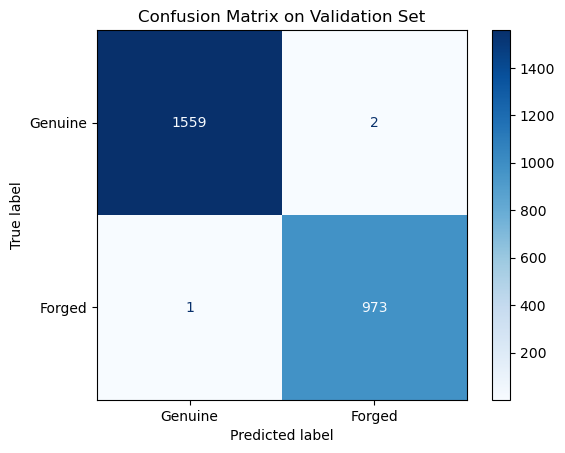

In [35]:

# === Confusion Matrix on Validation Set ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for img1, img2, labels in val_loader:
        img1, img2 = img1.to(device), img2.to(device)
        labels = labels.to(device)
        outputs = model(img1, img2)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Forged"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# =======================
# 1. Load Model
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SignatureNet(input_size=(1, 270, 650)).to(device)
model.load_state_dict(torch.load("best_signature_model.pth", map_location=device))
model.eval()

# =======================
# 2. Preprocessing
# =======================
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((270, 650)),
    transforms.ToTensor()
])

def preprocess_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Shape: (1, 1, 270, 650)
    return image.to(device)

# =======================
# 3. Prediction Function
# =======================
def predict_similarity(img1_path, img2_path):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    
    with torch.no_grad():
        output = model(img1, img2)
        similarity_score = torch.sigmoid(output).item()
    
    return similarity_score

# =======================
# 4. Determine Genuine vs Forged
# =======================
def determine_genuine(genuine_path, forged_path):
    # Option 1: assume one is real, the other is fake and compare to reference genuine
    # Option 2: compare both to a known genuine reference image (recommended for production)
    
    # Assuming genuine_path is more likely to be genuine
    score = predict_similarity(genuine_path, forged_path)
    
    print(f"Similarity score (0=fake, 1=real): {score:.4f}")
    if score > 0.5:
        print("Prediction: The first image is more likely genuine.")
    else:
        print("Prediction: The second image is more likely genuine.")

# =======================
# 5. Run Inference
# =======================
genuine_img_path = "path/to/genuine_signature.png"
forged_img_path = "path/to/forged_signature.png"

determine_genuine(genuine_img_path, forged_img_path)
